In [317]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Crea matrice  rating

In [318]:
N_PREV_GAMES = 6

In [319]:
def scored(row, team):
    if row['HomeTeam'] == team:
        return row.FTHG
    if row['AwayTeam'] == team:
        return row.FTAG
    
def conceded(row, team):
    if row['HomeTeam'] == team:
        return row.FTAG
    if row['AwayTeam'] == team:
        return row.FTHG

def calc_match_rating(row):
    h = row['HomeTeam']
    a = row['AwayTeam']
    i = row.id
    return all_team_stats[stats.loc[i].HomeTeam].loc[i].rating -\
            all_team_stats[stats.loc[i].AwayTeam].loc[i].rating

In [320]:
result = pd.DataFrame()

for year in range(2008,2021):
    print(year)
    filename = 'datasets/I1-' + str(year) + '.csv'
    #filename = 'datasets/E0-' + str(year) + '.csv'
    df = pd.read_csv(filename)
    df.dropna(how='all',inplace=True)  # droppa se tutta la riga è nan

    teams = df.HomeTeam.unique().tolist()
    print(teams)

    stats = df[['Date','HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']].copy()

    all_team_stats = {}

    for team in teams:
        team_stats = stats[(stats.HomeTeam == team)|(stats.AwayTeam == team)].copy()

        team_stats.loc[:,'scored'] = team_stats.apply(scored, team=team, axis=1)
        team_stats.loc[:,'conceded'] = team_stats.apply(conceded, team=team, axis=1)

        team_stats.loc[:,'rolling_scored'] = team_stats['scored'].rolling(window=N_PREV_GAMES).sum()
        team_stats.loc[:,'rolling_conceded'] = team_stats['conceded'].rolling(window=N_PREV_GAMES).sum()

        team_stats['rating'] = team_stats['rolling_scored'] - team_stats['rolling_conceded']
        team_stats['Date'] = pd.to_datetime(team_stats['Date'], infer_datetime_format=True)
        team_stats.rating = team_stats.rating.shift(1)

        all_team_stats[team] = team_stats

    stats['id'] = stats.index
    stats['match_rating'] = stats.apply(calc_match_rating, axis=1)

    result = result.append(stats)

2008
['Juventus', 'Lazio', 'Fiorentina', 'Genoa', 'Inter', 'Napoli', 'Palermo', 'Parma', 'Reggina', 'Siena', 'Empoli', 'Atalanta', 'Cagliari', 'Catania', 'Livorno', 'Roma', 'Sampdoria', 'Torino', 'Udinese', 'Milan']
2009
['Sampdoria', 'Udinese', 'Atalanta', 'Cagliari', 'Catania', 'Chievo', 'Fiorentina', 'Milan', 'Roma', 'Torino', 'Inter', 'Palermo', 'Bologna', 'Genoa', 'Juventus', 'Lazio', 'Lecce', 'Napoli', 'Reggina', 'Siena']
2010
['Bologna', 'Siena', 'Catania', 'Genoa', 'Inter', 'Juventus', 'Lazio', 'Livorno', 'Palermo', 'Udinese', 'Bari', 'Milan', 'Atalanta', 'Cagliari', 'Chievo', 'Fiorentina', 'Napoli', 'Parma', 'Roma', 'Sampdoria']
2011
['Roma', 'Udinese', 'Bari', 'Chievo', 'Fiorentina', 'Milan', 'Palermo', 'Parma', 'Sampdoria', 'Bologna', 'Cagliari', 'Cesena', 'Inter', 'Brescia', 'Catania', 'Genoa', 'Juventus', 'Lazio', 'Lecce', 'Napoli']
2012
['Milan', 'Cesena', 'Catania', 'Chievo', 'Fiorentina', 'Genoa', 'Juventus', 'Lecce', 'Palermo', 'Roma', 'Cagliari', 'Inter', 'Atalanta', 

In [321]:
result.dropna(inplace=True)

In [322]:
result.match_rating.describe()

count    3956.000000
mean       -0.297776
std         6.991583
min       -25.000000
25%        -5.000000
50%         0.000000
75%         4.000000
max        24.000000
Name: match_rating, dtype: float64

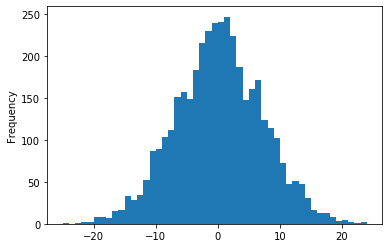

In [323]:
result.match_rating.plot(kind='hist', bins=49)

Salva la matrice

In [324]:
result.to_csv('rating_system.csv')

## Carica matrice rating

In [325]:
result = pd.read_csv('rating_system.csv')

In [326]:
df1 = result[['FTR','match_rating']]

In [327]:
df2 = df1.groupby('FTR')['match_rating'].value_counts()

In [328]:
dfH = pd.DataFrame(df2.H)
dfH.columns = ['H']
dfD = pd.DataFrame(df2.D)
dfD.columns = ['D']
dfA = pd.DataFrame(df2.A)
dfA.columns = ['A']

In [329]:
df3 = dfH.combine_first(dfD).combine_first(dfA)

In [330]:
df3.fillna(value=0, inplace=True)

In [331]:
df4 = df3[['H','D','A']].copy()

In [332]:
df4['pctH'] = df4['H']/(df4['H']+df4['D']+df4['A'])*100.0
df4['pctD'] = df4['D']/(df4['H']+df4['D']+df4['A'])*100.0
df4['pctA'] = df4['A']/(df4['H']+df4['D']+df4['A'])*100.0

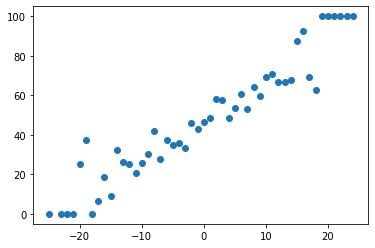

In [333]:
plt.scatter(df4.index,df4.pctH)

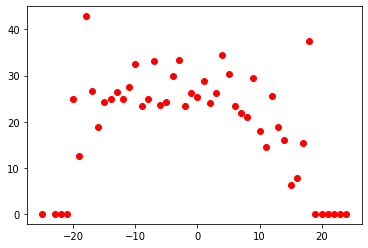

In [334]:
plt.scatter(df4.index,df4.pctD,color='r')

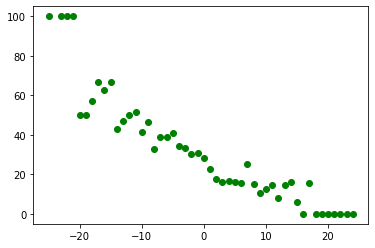

In [335]:
plt.scatter(df4.index,df4.pctA,color='g')

### Home: linear regression

In [396]:
from sklearn.linear_model import LinearRegression

In [435]:
reg = LinearRegression()
X = np.array(df4.index).reshape(-1, 1)
y = df4.pctH
reg.fit(X, y)

#X_test = np.linspace(-25,24,num=len(y))
y_pred = reg.predict(X.reshape(-1,1))

In [436]:
print(reg.coef_, reg.intercept_)

[2.00971505] 48.232858858597844


In [437]:
from sklearn.metrics import r2_score
r2_score(y, y_pred)

0.9156277445443289

In [438]:
home_reg = reg
home_X = X
home_y_pred = y_pred

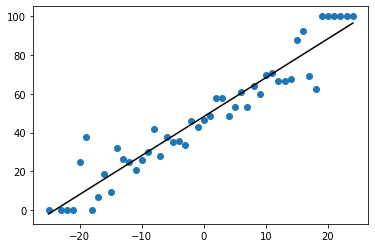

In [439]:
plt.scatter(df4.index,df4.pctH)
plt.plot(X,y_pred,'black')

### DRAW: linear regression + poly

In [440]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4,include_bias=False)


X = np.array(df4.index).reshape(-1, 1)
y = df4.pctD

X_new = poly.fit_transform(X)


In [441]:
reg = LinearRegression()
reg.fit(X_new, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [442]:
reg.coef_

array([-4.22060501e-01, -1.68610002e-02,  5.69533664e-04, -5.96150213e-05])

In [443]:
#X_test = np.linspace(-25,24,num=len(y))
y_pred = reg.predict(X_new)

In [444]:
r2_score(y, y_pred)

0.6442543667166147

In [445]:
draw_reg = reg
draw_X = X
draw_y_pred = y_pred

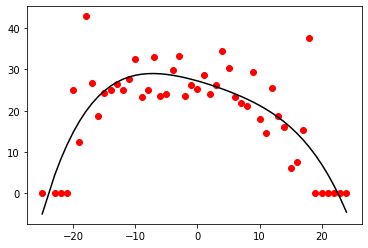

In [446]:
plt.scatter(df4.index,df4.pctD,color='r')
plt.plot(X,y_pred,'black')

### AWAY: linear regr + poly

In [447]:
X = np.array(df4.index).reshape(-1, 1)
y = df4.pctA
X_new = poly.fit_transform(X)

In [448]:
reg = LinearRegression()
reg.fit(X_new, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [449]:
reg.coef_

array([-1.35184409e+00,  4.80932736e-03, -1.22298515e-03,  5.91803454e-05])

In [450]:
#X_test = np.linspace(-25,24,num=len(y))
y_pred = reg.predict(X_new)

In [451]:
away_reg = reg
away_X = X
away_y_pred = y_pred

In [452]:
r2_score(y, y_pred)

0.9261540639620697

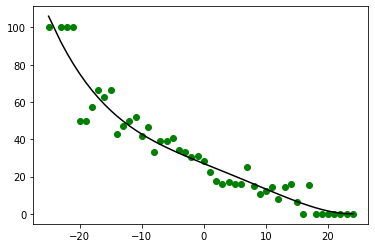

In [453]:
plt.scatter(df4.index,df4.pctA,color='g')
plt.plot(X,y_pred,'black')

## Matrice fair odds

In [489]:
fair_odds = pd.DataFrame(index=X[:,0])
fair_odds['rating'] = fair_odds.index
fair_odds['home_exp'] = home_y_pred
fair_odds['draw_exp'] = draw_y_pred
fair_odds['away_exp'] = away_y_pred

In [490]:
fair_odds = fair_odds.loc[-22:22]

In [493]:
fair_odds['total'] = fair_odds.home_exp + fair_odds.draw_exp + fair_odds.away_exp

In [497]:
fair_odds['fair_h_odds'] = fair_odds.total/fair_odds.home_exp
fair_odds['fair_a_odds'] = fair_odds.total/fair_odds.away_exp
fair_odds['fair_d_odds'] = fair_odds.total/fair_odds.draw_exp

In [498]:
fair_odds

,rating,home_exp,draw_exp,away_exp,total,fair_h_odds,fair_a_odds,fair_d_odds
-22.0,-22.0,4.019128,8.316644,85.934497,98.270268,24.450646,1.143549,11.816097
-21.0,-21.0,6.028843,11.780737,80.325673,98.135253,16.277627,1.221717,8.330146
-20.0,-20.0,8.038558,14.823745,75.193865,98.056168,12.198229,1.304045,6.614804
-19.0,-19.0,10.048273,17.478416,70.502618,98.029306,9.755836,1.390435,5.608592
-18.0,-18.0,12.057988,19.776066,66.216897,98.050951,8.131618,1.480754,4.958061
-17.0,-17.0,14.067703,21.746582,62.303089,98.117374,6.974655,1.574840,4.511853
-16.0,-16.0,16.077418,23.418420,58.728999,98.224837,6.109491,1.672510,4.194341
-15.0,-15.0,18.087133,24.818604,55.463856,98.369592,5.438650,1.773580,3.963543
-14.0,-14.0,20.096848,25.972728,52.478305,98.547880,4.903649,1.877879,3.794283
-13.0,-13.0,22.106563,26.904955,49.744414,98.755932,4.467268,1.985267,3.670548


In [503]:
filename = 'datasets/I1-2020.csv'
#filename = 'datasets/E0-' + str(year) + '.csv'
df = pd.read_csv(filename)
df.dropna(how='all',inplace=True)  # droppa se tutta la riga è nan

teams = df.HomeTeam.unique().tolist()
print(teams)

stats = df[['Date','HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']].copy()

all_team_stats = {}

for team in teams:
    team_stats = stats[(stats.HomeTeam == team)|(stats.AwayTeam == team)].copy()

    team_stats.loc[:,'scored'] = team_stats.apply(scored, team=team, axis=1)
    team_stats.loc[:,'conceded'] = team_stats.apply(conceded, team=team, axis=1)

    team_stats.loc[:,'rolling_scored'] = team_stats['scored'].rolling(window=N_PREV_GAMES).sum()
    team_stats.loc[:,'rolling_conceded'] = team_stats['conceded'].rolling(window=N_PREV_GAMES).sum()

    team_stats['rating'] = team_stats['rolling_scored'] - team_stats['rolling_conceded']
    team_stats['Date'] = pd.to_datetime(team_stats['Date'], infer_datetime_format=True)
    team_stats.rating = team_stats.rating.shift(1)

    all_team_stats[team] = team_stats

stats['id'] = stats.index
stats['match_rating'] = stats.apply(calc_match_rating, axis=1)


['Parma', 'Fiorentina', 'Udinese', 'Cagliari', 'Roma', 'Sampdoria', 'Spal', 'Torino', 'Verona', 'Inter', 'Bologna', 'Milan', 'Juventus', 'Lazio', 'Atalanta', 'Genoa', 'Lecce', 'Sassuolo', 'Napoli', 'Brescia']


In [513]:
stats.tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,id,match_rating
210,01/02/2020,Cagliari,Parma,2,2,D,210,-7.0
211,01/02/2020,Sassuolo,Roma,4,2,H,211,-6.0
212,02/02/2020,Juventus,Fiorentina,3,0,H,212,8.0
213,02/02/2020,Atalanta,Genoa,2,2,D,213,22.0
214,02/02/2020,Lazio,Spal,5,1,H,214,14.0
215,02/02/2020,Milan,Verona,1,1,D,215,-6.0
216,02/02/2020,Lecce,Torino,4,0,H,216,-4.0
217,02/02/2020,Udinese,Inter,0,2,A,217,-6.0
218,03/02/2020,Sampdoria,Napoli,2,4,A,218,4.0
219,05/02/2020,Lazio,Verona,0,0,D,219,5.0


In [510]:
all_team_stats['Juventus'].loc[212]

Date                2020-02-02 00:00:00
HomeTeam                       Juventus
AwayTeam                     Fiorentina
FTHG                                  3
FTAG                                  0
FTR                                   H
scored                                3
conceded                              0
rolling_scored                       14
rolling_conceded                      5
rating                                8
Name: 212, dtype: object

In [511]:
all_team_stats['Fiorentina'].loc[212]

Date                2020-02-02 00:00:00
HomeTeam                       Juventus
AwayTeam                     Fiorentina
FTHG                                  3
FTAG                                  0
FTR                                   H
scored                                0
conceded                              3
rolling_scored                        5
rolling_conceded                      8
rating                                0
Name: 212, dtype: object